In [14]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

from sklearn.metrics import mean_squared_log_error

## Data

In [7]:
paths = ["/var/data/train.csv","/var/data/test.csv"]
target_name = "SalePrice"

## Reading and cleaning

In [8]:
rd = Reader(sep = ',')
df = rd.train_test_split(paths, target_name)


reading csv : train.csv ...
cleaning data...
CPU time: 32.33097958564758 seconds

reading csv : test.csv ...
cleaning data...
CPU time: 0.14587616920471191 seconds

number of common features : 80

Gathering and crunching for train and test datasets
reindexing for train and test datasets
Dropping training duplicates
Dropping constant variables on training set

number of categorical features: 43
number of numerical features: 37
number of training samples : 1460
number of test samples : 1459

Top sparse features (% missing values on train set):
PoolQC         99.5
MiscFeature    96.3
Alley          93.8
Fence          80.8
FireplaceQu    47.3
dtype: float64

task : regression


## Drift variables

In general, we assume that train and test dataset are created through the same generative algorithm or process but this assumption is quite strong and we do not see this behaviour in the real world. In the real world, the data generator or the process may change. For example, in a sales prediction model, the customer behaviour changes over time and hence the data generated will be different than the data that was used to create the model. This is called drift.

[Tutorial on Automated Machine Learning using MLBox](https://www.analyticsvidhya.com/blog/2017/07/mlbox-library-automated-machine-learning/)

In [9]:
dft = Drift_thresholder()
df = dft.fit_transform(df)


computing drifts...
CPU time: 0.6662700176239014 seconds

Top 10 drifts

('Id', 0.9993141289437586)
('GarageYrBlt', 0.058603155187046063)
('Exterior1st', 0.051728220022389637)
('TotalBsmtSF', 0.047797384757831907)
('2ndFlrSF', 0.042466584861516665)
('Exterior2nd', 0.042145856162453033)
('BsmtFullBath', 0.040377812116377587)
('GrLivArea', 0.039437274266823197)
('TotRmsAbvGrd', 0.038939865235153803)
('WoodDeckSF', 0.037307853783462352)

deleted variables : ['Id']

dumping drift coefficients into directory : save
drift coefficients dumped


## Tuning

### Scoring function

In [18]:
log_rmse = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred), 
                       greater_is_better=False, needs_proba=False)

opt = Optimiser(scoring=log_rmse, n_folds=5)

/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:78: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


### Evaluate data

Evaluates the data with a given scoring function and given hyper-parameters of the whole pipeline. If no parameters are set, default configuration for each step is evaluated : no feature selection is applied and no meta features are created.

[MLbox Github](https://github.com/AxeldeRomblay/MLBox/blob/master/python-package/mlbox/optimisation/optimiser.py)

In [19]:
opt.evaluate(None, df)

No parameters set. Default configuration is tested

##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'max_depth': -1, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0573525545037
VARIANCE : 0.00801971015329 (fold 1 = -0.0661025431512, fold 2 = -0.0680459918551, fold 3 = -0.0508326011678, fold 4 = -0.0524154470867, fold 5 = -0.0493661892576)
CPU time: 3.9

-0.057352554503668753

### Hyper-parameter space

Let us now create our hyper-parameter space. Before that, remember, hyper-parameter is a dictionary of key and value pairs where value is also a dictionary given by the syntax {“search”:strategy,”space”:list}, where strategy can be either “choice” or “uniform” and list is the list of values.

[Tutorial on Automated Machine Learning using MLBox](https://www.analyticsvidhya.com/blog/2017/07/mlbox-library-automated-machine-learning/)

In [ ]:
space = {'ne__numerical_strategy':{"search":"choice", "space":[0]},
         'ce__strategy':{"search":"choice", "space":["label_encoding","random_projection", "entity_embedding"]}, 
         'fs__threshold':{"search":"uniform", "space":[0.01,0.3]}, 
         'est__max_depth':{"search":"choice", "space":[3,4,5,6,7]}}

### Optimise

In [22]:
best = opt.optimise(space, df, 40)


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.04847908753260764}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 50000, 'subsample_freq': 1}



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0587382652978
VARIANCE : 0.00815203502116 (fold 1 = -0.0677000554774, fold 2 = -0.0695987903033, fold 3 = -0.0522394938701, fold 4 = -0.0533055680943, fold 5 = -0.0508474187438)
CPU time: 5.278612375259399 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1183389685681974}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0588659531367
VARIANCE : 0.00813519722245 (fold 1 = -0.0681080693048, fold 2 = -0.069404293028, fold 3 = -0.0524302427342, fold 4 = -0.0536032546679, fold 5 = -0.0507839059485)
CPU time: 5.009919166564941 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01753179817857982}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0574792059249
VARIANCE : 0.00814314578399 (fold 1 = -0.066342569573, fold 2 = -0.0683432898457, fold 3 = -0.0508341817846, fold 4 = -0.0525559148658, fold 5 = -0.0493200735555)
CPU time: 6.337275981903076 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.18660137184204909}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsamp

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0578145570288
VARIANCE : 0.00810266250115 (fold 1 = -0.0666355253637, fold 2 = -0.0686626359083, fold 3 = -0.0509402014717, fold 4 = -0.0527711995069, fold 5 = -0.0500632228934)
CPU time: 5.168642282485962 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.21533550255790518}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'sub

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0648699802381
VARIANCE : 0.00759138036166 (fold 1 = -0.0727969425103, fold 2 = -0.0753992871041, fold 3 = -0.0594195629991, fold 4 = -0.0586491049441, fold 5 = -0.0580850036331)
CPU time: 3.8951573371887207 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.12786301815596252}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'su

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0588725829454
VARIANCE : 0.00815363193027 (fold 1 = -0.0679248278481, fold 2 = -0.0696244105037, fold 3 = -0.0524620713758, fold 4 = -0.0536032546679, fold 5 = -0.0507483503313)
CPU time: 5.344588994979858 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.037298959281134074}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'su

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0634057234242
VARIANCE : 0.00785207808724 (fold 1 = -0.0718389564552, fold 2 = -0.0740643869384, fold 3 = -0.0569103276848, fold 4 = -0.0581132170464, fold 5 = -0.0561017289961)
CPU time: 3.869889497756958 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.10569397842879835}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0633393050428
VARIANCE : 0.00779524965834 (fold 1 = -0.0712302975898, fold 2 = -0.0743035603272, fold 3 = -0.0562808566591, fold 4 = -0.0584265514711, fold 5 = -0.056455259167)
CPU time: 6.56510329246521 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.10015894607508499}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsampl

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0606648431133
VARIANCE : 0.0077696409269 (fold 1 = -0.0695321842785, fold 2 = -0.0707553994414, fold 3 = -0.0537715691417, fold 4 = -0.0553716990955, fold 5 = -0.0538933636094)
CPU time: 3.4176831245422363 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05624101561617222}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0576665597998
VARIANCE : 0.00812533201179 (fold 1 = -0.0663470129008, fold 2 = -0.0686720516073, fold 3 = -0.0508083770447, fold 4 = -0.0527229803772, fold 5 = -0.0497823770687)
CPU time: 8.79254674911499 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.15439665420204177}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsa

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.058819909436
VARIANCE : 0.00804413743871 (fold 1 = -0.0673187698738, fold 2 = -0.0698149685972, fold 3 = -0.0518400470429, fold 4 = -0.0538666231515, fold 5 = -0.0512591385149)
CPU time: 7.288628578186035 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.013015381546833642}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'sub

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0574792059249
VARIANCE : 0.00814314578399 (fold 1 = -0.066342569573, fold 2 = -0.0683432898457, fold 3 = -0.0508341817846, fold 4 = -0.0525559148658, fold 5 = -0.0493200735555)
CPU time: 6.413805723190308 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.08104397242518768}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0634028525604
VARIANCE : 0.00785445466266 (fold 1 = -0.0718389564552, fold 2 = -0.0740643869384, fold 3 = -0.0568959733661, fold 4 = -0.0581132170464, fold 5 = -0.0561017289961)
CPU time: 3.980926752090454 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.18615025647725805}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'sub

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0611111991128
VARIANCE : 0.00755225394033 (fold 1 = -0.0698568503979, fold 2 = -0.0708083957096, fold 3 = -0.0553541056998, fold 4 = -0.0554937017347, fold 5 = -0.0540429420221)
CPU time: 4.03567361831665 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.27359747228527176}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsa

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.058819909436
VARIANCE : 0.00804413743871 (fold 1 = -0.0673187698738, fold 2 = -0.0698149685972, fold 3 = -0.0518400470429, fold 4 = -0.0538666231515, fold 5 = -0.0512591385149)
CPU time: 7.589314222335815 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.21760129525462368}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsamp

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0645806072096
VARIANCE : 0.00738939397327 (fold 1 = -0.0731007184917, fold 2 = -0.0740928073911, fold 3 = -0.0595872302239, fold 4 = -0.0580804794601, fold 5 = -0.0580418004814)
CPU time: 2.767510175704956 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.27759526892498815}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'sub

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0585588814131
VARIANCE : 0.00762915271779 (fold 1 = -0.0667865350132, fold 2 = -0.0687762828874, fold 3 = -0.0536066311103, fold 4 = -0.0531120185492, fold 5 = -0.0505129395052)
CPU time: 5.091106653213501 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.13218738473833513}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'sub

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0606624125261
VARIANCE : 0.00767893190566 (fold 1 = -0.0698338891957, fold 2 = -0.0702419913975, fold 3 = -0.0540985863547, fold 4 = -0.0554625446003, fold 5 = -0.0536750510821)
CPU time: 4.245377063751221 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.05171020203348648}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsam

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0605865425547
VARIANCE : 0.00781234514908 (fold 1 = -0.0694645355837, fold 2 = -0.0707553994414, fold 3 = -0.0538736149585, fold 4 = -0.0553716990955, fold 5 = -0.0534674636943)
CPU time: 3.5530929565429688 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.08168001017620469}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'su

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0587727257995
VARIANCE : 0.008136620629 (fold 1 = -0.067658174074, fold 2 = -0.0696342724707, fold 3 = -0.0522333159847, fold 4 = -0.0536032546679, fold 5 = -0.0507346118002)
CPU time: 10.2969388961792 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.010686732559839108}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsam

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.05780709748
VARIANCE : 0.00815044152376 (fold 1 = -0.0665457595203, fold 2 = -0.0688198680817, fold 3 = -0.0510855687212, fold 4 = -0.0527812741643, fold 5 = -0.0498030169128)
CPU time: 5.55716609954834 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.010223489428989284}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsa

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0574792059249
VARIANCE : 0.00814314578399 (fold 1 = -0.066342569573, fold 2 = -0.0683432898457, fold 3 = -0.0508341817846, fold 4 = -0.0525559148658, fold 5 = -0.0493200735555)
CPU time: 6.195605993270874 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01128571805684625}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0574792059249
VARIANCE : 0.00814314578399 (fold 1 = -0.066342569573, fold 2 = -0.0683432898457, fold 3 = -0.0508341817846, fold 4 = -0.0525559148658, fold 5 = -0.0493200735555)
CPU time: 5.876037836074829 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.02869569852696094}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0574792059249
VARIANCE : 0.00814314578399 (fold 1 = -0.066342569573, fold 2 = -0.0683432898457, fold 3 = -0.0508341817846, fold 4 = -0.0525559148658, fold 5 = -0.0493200735555)
CPU time: 6.246106863021851 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.08840978250507983}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0578521057592
VARIANCE : 0.00811373841873 (fold 1 = -0.0665457595203, fold 2 = -0.0688198680817, fold 3 = -0.051310610117, fold 4 = -0.0527812741643, fold 5 = -0.0498030169128)
CPU time: 5.786031246185303 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.06563360524721827}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0574792059249
VARIANCE : 0.00814314578399 (fold 1 = -0.066342569573, fold 2 = -0.0683432898457, fold 3 = -0.0508341817846, fold 4 = -0.0525559148658, fold 5 = -0.0493200735555)
CPU time: 6.492783546447754 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.06393409174335596}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsa

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0576665597998
VARIANCE : 0.00812533201179 (fold 1 = -0.0663470129008, fold 2 = -0.0686720516073, fold 3 = -0.0508083770447, fold 4 = -0.0527229803772, fold 5 = -0.0497823770687)
CPU time: 8.508369445800781 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.03650466784253245}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'sub

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0574792059249
VARIANCE : 0.00814314578399 (fold 1 = -0.066342569573, fold 2 = -0.0683432898457, fold 3 = -0.0508341817846, fold 4 = -0.0525559148658, fold 5 = -0.0493200735555)
CPU time: 5.8168981075286865 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.06972507429032829}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsam

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0578849153763
VARIANCE : 0.00801914901879 (fold 1 = -0.0664141191959, fold 2 = -0.0687759471754, fold 3 = -0.0514216247824, fold 4 = -0.0528991796117, fold 5 = -0.0499137061163)
CPU time: 4.357239484786987 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.16003932118101966}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'sub

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0578362505421
VARIANCE : 0.00804995255591 (fold 1 = -0.0664462844463, fold 2 = -0.0687156443164, fold 3 = -0.0518715102123, fold 4 = -0.0525702485561, fold 5 = -0.0495775651796)
CPU time: 5.503585577011108 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.03348860951457437}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'sub

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0574792059249
VARIANCE : 0.00814314578399 (fold 1 = -0.066342569573, fold 2 = -0.0683432898457, fold 3 = -0.0508341817846, fold 4 = -0.0525559148658, fold 5 = -0.0493200735555)
CPU time: 6.427258491516113 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.29886162731121957}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsamp

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0591096167084
VARIANCE : 0.00751774367685 (fold 1 = -0.0669016156089, fold 2 = -0.069543370566, fold 3 = -0.0518214595404, fold 4 = -0.0534522055794, fold 5 = -0.0538294322475)
CPU time: 4.353944778442383 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.012926401195766664}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'sub

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.05780709748
VARIANCE : 0.00815044152376 (fold 1 = -0.0665457595203, fold 2 = -0.0688198680817, fold 3 = -0.0510855687212, fold 4 = -0.0527812741643, fold 5 = -0.0498030169128)
CPU time: 6.086341857910156 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.027249688907912496}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsa

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0576665597998
VARIANCE : 0.00812533201179 (fold 1 = -0.0663470129008, fold 2 = -0.0686720516073, fold 3 = -0.0508083770447, fold 4 = -0.0527229803772, fold 5 = -0.0497823770687)
CPU time: 9.24239730834961 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.11368980876774236}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.057578916603
VARIANCE : 0.0081966640037 (fold 1 = -0.0664934740677, fold 2 = -0.0685279741278, fold 3 = -0.0509405502461, fold 4 = -0.0525559148658, fold 5 = -0.0493766697074)
CPU time: 6.183487892150879 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2211355943055377}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsam

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0579629071468
VARIANCE : 0.00787308232667 (fold 1 = -0.0665465572471, fold 2 = -0.0684771089745, fold 3 = -0.0515674993166, fold 4 = -0.0530473649279, fold 5 = -0.0501760052677)
CPU time: 5.776554584503174 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.23495659667580354}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subsam

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0598052319028
VARIANCE : 0.00784547770891 (fold 1 = -0.0686992653323, fold 2 = -0.0700343040252, fold 3 = -0.0539203944387, fold 4 = -0.0541248929148, fold 5 = -0.052247302803)
CPU time: 4.201648712158203 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.14025153289340017}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.063475636655
VARIANCE : 0.00796985188431 (fold 1 = -0.0719514022962, fold 2 = -0.0743501398077, fold 3 = -0.0570035050182, fold 4 = -0.0581957869995, fold 5 = -0.0558773491534)
CPU time: 3.5096161365509033 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.04375777333015028}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0603897721385
VARIANCE : 0.00760606603943 (fold 1 = -0.0687497833475, fold 2 = -0.0704884223208, fold 3 = -0.0534838073578, fold 4 = -0.0558307838908, fold 5 = -0.0533960637756)
CPU time: 7.09305477142334 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.17666480981008054}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_bin': 255, 'min_child_samples': 10, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 500, 'nthread': -1, 'num_leaves': 31, 'objective': 'regression', 'reg_alpha': 0, 'reg_lambda': 0, 'seed': 0, 'silent': True, 'subsample': 0.9, 'subs

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -0.0578592500521
VARIANCE : 0.0081453437252 (fold 1 = -0.0668352420507, fold 2 = -0.0686487110663, fold 3 = -0.0516249057786, fold 4 = -0.052566740199, fold 5 = -0.049620651166)
CPU time: 6.293211936950684 seconds



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ BEST HYPER-PARAMETERS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'ce__strategy': 'random_projection', 'est__max_depth': 7, 'fs__threshold': 0.01753179817857982, 'ne__numerical_strategy': 0}


In [46]:
best

{'ce__strategy': 'random_projection',
 'est__max_depth': 7,
 'fs__threshold': 0.01753179817857982,
 'ne__numerical_strategy': 0}

### Prediction


fitting the pipeline...


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


CPU time: 17.510568380355835 seconds

dumping feature importances into directory : save


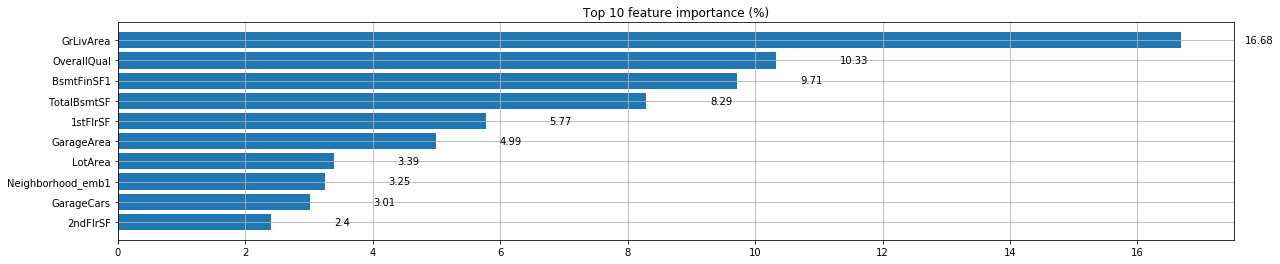


predicting...
CPU time: 0.2551443576812744 seconds

top 10 predictions :

   SalePrice_predicted
0        133286.301282
1        148207.969545
2        175811.294455
3        184898.665275
4        198578.963206
5        174078.691204
6        166258.146061
7        167770.769651
8        180169.853741
9        133884.427204

dumping predictions into directory : save


In [21]:
prd = Predictor()
prd.fit_predict(best, df)

### Save for kaggle submission

In [45]:
# Create the csv file for submission
sales_pred_df = pd.read_csv('/var/docker/save/SalePrice_predictions.csv', header=0, names=['index', 'SalePrice'], 
                            index_col='index')
sales_pred_df['Id'] = np.arange(1461, 2920)
sales_pred_df.to_csv('/var/docker/save/mlbox_sales_pred.csv', index = False)

In [32]:
1461 + 1459 - 1

2919